In [300]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [301]:
#Read CSV file
df = pd.read_csv("Nat_Gas.csv")
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [302]:
#Extract month and year 
import datetime as dt
df['Dates'] = pd.to_datetime(df['Dates'])
df['Month'] = pd.to_datetime(df['Dates']).dt.month
df['Year'] = pd.to_datetime(df['Dates']).dt.year

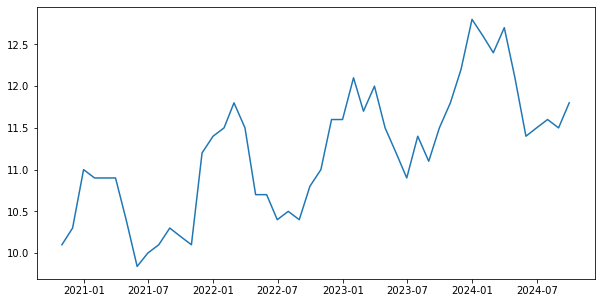

In [303]:
#Plot the natural gas prices
plt.figure(figsize = (10,5))
plt.plot(df['Dates'], df['Prices'])

## ARIMA Model

In [321]:
#Check if the data is stationary:
from statsmodels.tsa.stattools import adfuller
def ad_fuller(data):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(data, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

print(ad_fuller(df['Prices']))

Dickey-Fuller Test indicates:
Test Statistic                 -2.058395
p-value                         0.569301
#Lags Used                     10.000000
Number of Observations Used    37.000000
dtype: float64
None


In [305]:
#Calculate the First Difference of the Prices:
df1 = df.copy()
df1['Price First Difference'] = df1['Prices'] - df1['Prices'].shift(1)
df1['Seasonal First Difference']=df1['Prices']-df1['Prices'].shift(12)
df1.head()

,Dates,Prices,Month,Year,Price First Difference,Seasonal First Difference
0,2020-10-31,10.1,10,2020,NaN,NaN
1,2020-11-30,10.3,11,2020,0.2,NaN
2,2020-12-31,11.0,12,2020,0.7,NaN
3,2021-01-31,10.9,1,2021,-0.1,NaN
4,2021-02-28,10.9,2,2021,0.0,NaN


In [306]:
#Drop the NA values:
ad_fuller(df1['Seasonal First Difference'].dropna())

Dickey-Fuller Test indicates:
Test Statistic                -6.204571e+00
p-value                        8.081143e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.500000e+01
dtype: float64


C:\Users\Dhanashri\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


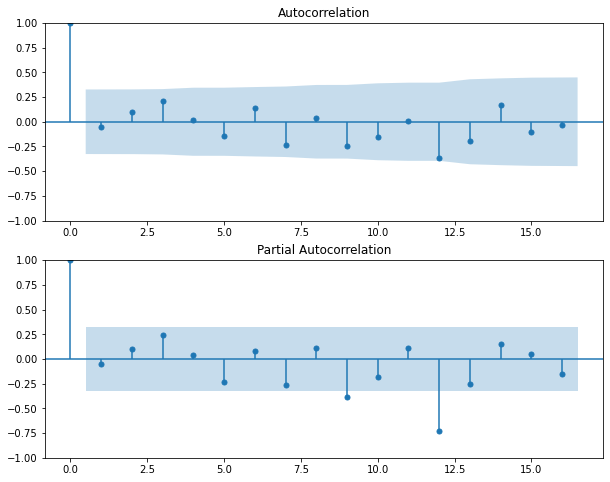

In [322]:
#Autocorrelation and Partial Autocorrelation to decide which ARIMA model to use:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1['Seasonal First Difference'].dropna(),ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1['Seasonal First Difference'].dropna(),ax=ax2)

In [308]:
#ARIMA model without seasonality:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df['Prices'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Prices   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -22.151
Date:                Fri, 05 Jan 2024   AIC                             50.303
Time:                        19:24:42   BIC                             55.853
Sample:                             0   HQIC                            52.391
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3718      1.748      0.213      0.832      -3.054       3.798
ma.L1         -0.2817      1.787     -0.158      0.875      -3.784       3.221
sigma2         0.1502      0.031      4.822      0.000       0.089       0.211
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.86   Prob(JB):                         0.94
Heteroskedasticity (H):               0.93   Skew:                             0.12
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

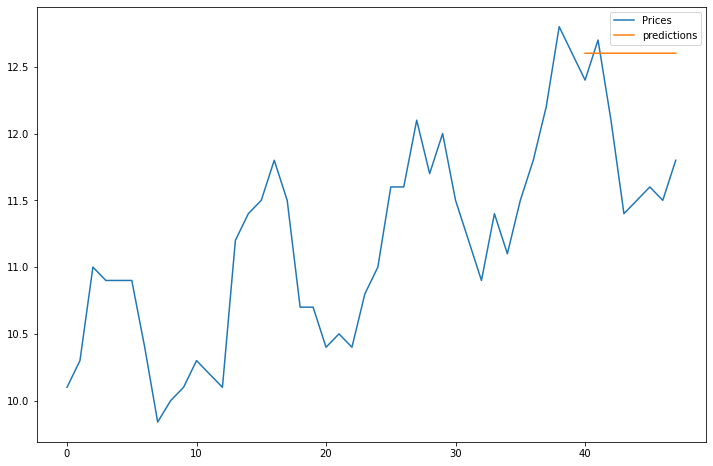

In [309]:
#Plotting the predictions:
df1['predictions']=model_fit.predict(start=40,end=47,dynamic=True)
df1[['Prices','predictions']].plot(figsize=(12,8))

C:\Users\Dhanashri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<AxesSubplot:>

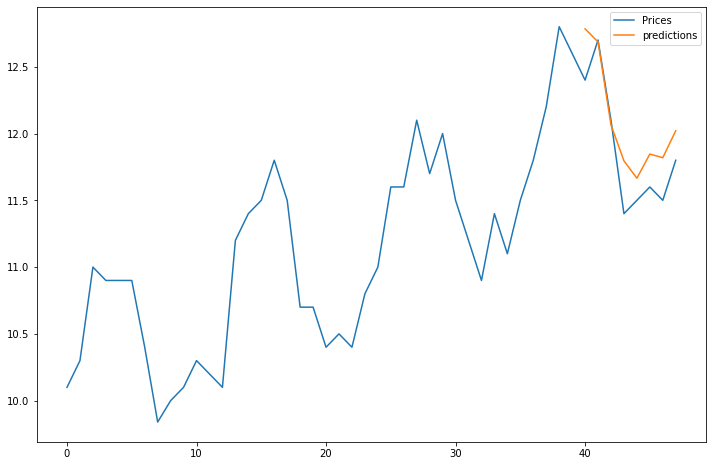

In [310]:
#ARIMA model with seasonality:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Prices'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
#PLotting the predictions for the new model:
df1['predictions']=results.predict(start=40,end=48,dynamic=True)
df1[['Prices','predictions']].plot(figsize=(12,8))

In [311]:
#Create the future dates data:
def last_year(year):
    dates = []
    current_date = dt.datetime(year, 12,31)
    while current_date.year == year:
        dates.append(current_date.strftime("%m/%d/%Y"))
        month = current_date.month
        year = current_date.year
        
        current_date = current_date.replace(year = year, month = month, day = 1)
        current_date -= dt.timedelta(days = 1)
    return dates[::-1]

In [312]:
dates_2024 = last_year(2024)
dates_2024 = dates_2024[9:]
dates_2024

['10/31/2024', '11/30/2024', '12/31/2024']

In [313]:
dates_2025 = last_year(2025) 

In [314]:
#Future Dates
future_dates = pd.concat([pd.Series(dates_2024), pd.Series(dates_2025)], axis = 0, ignore_index = True)
future_dates

0     10/31/2024
1     11/30/2024
2     12/31/2024
3     01/31/2025
4     02/28/2025
5     03/31/2025
6     04/30/2025
7     05/31/2025
8     06/30/2025
9     07/31/2025
10    08/31/2025
11    09/30/2025
12    10/31/2025
13    11/30/2025
14    12/31/2025
dtype: object

In [315]:
#Future Prices
future_prices = results.forecast(steps = 15)

In [316]:
#Create the final future data:
future_df = pd.DataFrame({"Dates":future_dates, "Prices": list(future_prices)})
future_df['Dates'] = pd.to_datetime(future_df['Dates'])
future_df['Month'] = future_df['Dates'].dt.month
future_df['Year'] = future_df['Dates'].dt.year

In [317]:
#Concat the actual data and future data:
final_df = pd.concat([df, future_df], ignore_index = True)
final_df

,Dates,Prices,Month,Year
0,2020-10-31,10.100000,10,2020
1,2020-11-30,10.300000,11,2020
2,2020-12-31,11.000000,12,2020
3,2021-01-31,10.900000,1,2021
4,2021-02-28,10.900000,2,2021
...,...,...,...,...
58,2025-08-31,12.131916,8,2025
59,2025-09-30,12.378172,9,2025
60,2025-10-31,12.566265,10,2025
61,2025-11-30,13.156550,11,2025


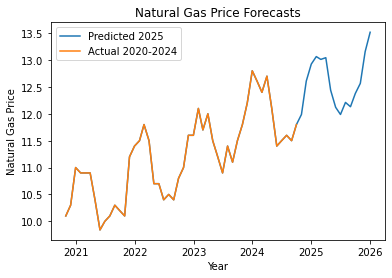

In [318]:
#PLot the actual and predicted data:
plt.plot(final_df['Dates'], final_df['Prices'], label = "Predicted 2025")
plt.plot(df['Dates'], df['Prices'], label = "Actual 2020-2024")
plt.ylabel("Natural Gas Price")
plt.xlabel("Year")
plt.title("Natural Gas Price Forecasts")
plt.legend()

In [319]:
#Function to extract price for specific month and year:
def get_price(month, year):
    print(f"The natural gas price for {month} in {year} = {final_df[(final_df['Month'] == month) & (final_df['Year'] == year)]['Prices'].values}")
    

In [320]:
get_price(11, 2020)

The natural gas price for 11 in 2020 = [10.3]
